In [55]:
#python request_public_data.py 2016-09-23-00 2016-09-25-00 https://e-mission.eecs.berkeley.edu -v
#data of moto E only 
'''
{ u'uuid': UUID('70968068-dba5-406c-8e26-09b548da0e4b'), u'user_email': u'nexus7itu01@gmail.com'}
{ u'uuid': UUID('6561431f-d4c1-4e0f-9489-ab1190341fb7'), u'user_email': u'nexus7itu02@gmail.com'}
{ u'uuid': UUID('92cf5840-af59-400c-ab72-bab3dcdf7818'), u'user_email': u'motoeitu01@gmail.com'}
{ u'uuid': UUID('93e8a1cc-321f-4fa9-8c3c-46928668e45d'), u'user_email': u'motoeitu02@gmail.com'}
'''

"\n{ u'uuid': UUID('70968068-dba5-406c-8e26-09b548da0e4b'), u'user_email': u'nexus7itu01@gmail.com'}\n{ u'uuid': UUID('6561431f-d4c1-4e0f-9489-ab1190341fb7'), u'user_email': u'nexus7itu02@gmail.com'}\n{ u'uuid': UUID('92cf5840-af59-400c-ab72-bab3dcdf7818'), u'user_email': u'motoeitu01@gmail.com'}\n{ u'uuid': UUID('93e8a1cc-321f-4fa9-8c3c-46928668e45d'), u'user_email': u'motoeitu02@gmail.com'}\n"

In [56]:
from uuid import UUID
import sys
import logging 
import arrow
import pandas as pd
#import public_data

import matplotlib.pyplot as plt
%matplotlib inline
import datetime as pydt
import emission.core.get_database as edb
import emission.storage.timeseries.abstract_timeseries as esta
import emission.storage.timeseries.timequery as estt

logging.getLogger().setLevel(logging.DEBUG)
logger = logging.getLogger()
#logger.handlers[0].stream = sys.stdout

In [57]:
#"70968068-dba5-406c-8e26-09b548da0e4b", "6561431f-d4c1-4e0f-9489-ab1190341fb7",
android_ids = [
             "92cf5840-af59-400c-ab72-bab3dcdf7818", "93e8a1cc-321f-4fa9-8c3c-46928668e45d"]

In [58]:
logger.setLevel(logging.CRITICAL)

# oct: video playback
#start_ts = 1475504400 #2016-10-02-02
#end_ts = 1475580800 #2016-10-05-02
# sept: location tracking
#start_ts = 1474009200 #2016-09-16-03
#end_ts = 1474873200 #2016-09-26-03

#phone 1&2
start_ts = arrow.get('2016-10-14T09:52:01.293000+02:00').timestamp
end_ts = arrow.get('2016-10-16T06:32:21.525000+02:00').timestamp

#phone 3&4
#start_ts = arrow.get('2016-09-20T16:14:28.795000+02:00').timestamp
#end_ts = arrow.get('2016-09-22T17:45:32.878000+02:00').timestamp


android_ts = map(lambda u: esta.TimeSeries.get_time_series(UUID(u)), android_ids)

#time query specification
time_range = estt.TimeQuery("metadata.write_ts", start_ts, end_ts)

android_state_df_list = map(lambda t:t.get_data_df("statemachine/transition", time_range), android_ts)

android_battery_df_list = map(lambda t:t.get_data_df("background/battery", time_range), android_ts)

#android_battery_df_list = map(lambda d:d[d.battery_status!=2], android_battery_df_list)

In [59]:
android_test = android_state_df_list[0]

In [60]:
android_test = android_battery_df_list[1]
android_test[['fmt_time', 'battery_level_pct', 'battery_status']][(android_test['battery_level_pct'] == 100.0)]

,fmt_time,battery_level_pct,battery_status
0,2016-10-14T10:42:36.055000+02:00,100.0,1


In [61]:
import numpy as np

android_xnew = np.arange(start_ts, end_ts, 15 * 60) # 15 minutes

In [62]:
import scipy.interpolate as spi
import numpy as np

def get_interpolated(x, y, xnew):
    # fn = spi.interp1d(x=x, y=y, bounds_error=False, fill_value=y.iloc[-1])
    fn = spi.interp1d(x=x, y=y, bounds_error=False)
    return fn(xnew)
def get_interpolated_df(sensor_df, xnew):
    local_dt_new = map(pydt.datetime.fromtimestamp, xnew)
    fmt_time_new = map(lambda dt: dt.isoformat(), local_dt_new)
    interpolated_series = get_interpolated(sensor_df.ts, sensor_df.battery_level_pct, xnew)
    interpolated_df = pd.DataFrame(data={'ts': xnew, 'metadata_write_ts': xnew, 'local_dt': local_dt_new, 'fmt_time': fmt_time_new, 'battery_level_pct': interpolated_series})
    return interpolated_df

In [63]:
android_battery_interp_df_list = map(lambda df: get_interpolated_df(df, android_xnew), android_battery_df_list)

In [67]:
title = "android_jonathan (video playback)"
#label = ['"Nexus7"-1', '"Nexus7"-2','"Moto E"-1', '"Moto E"-2']
label = ['"Moto E"-1', '"Moto E"-2']

style = ['ob', 'og', 'or', 'oc']
style_interp = ['b', 'g', 'r', 'c']
#style_interp = ['b', 'g']
#style = ['ob', 'og']

ts_to_dt = lambda t: pydt.datetime.fromtimestamp(t)

About to plot 0
About to plot 1
About to plot 0
About to plot 1


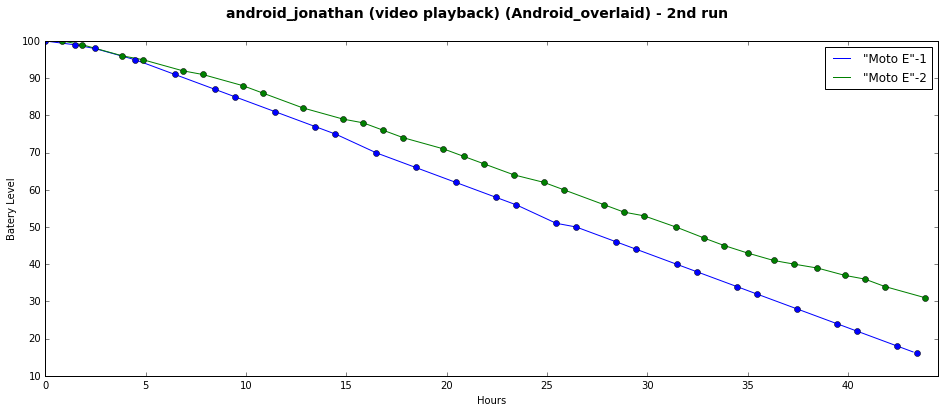

In [68]:
#Android: With interplation on battery data 

(ifig, iaxes2d) = plt.subplots(ncols=1, nrows=1, figsize=(16,6))
iaxes = iaxes2d

ifig.suptitle(title + ' (Android_overlaid) - 2nd run', fontsize=14, fontweight='bold')
#'''
for i, df in enumerate(android_battery_interp_df_list):
    print "About to plot %d" % i
    df['hr'] = (df.ts-start_ts)/3600.0
    df.plot(x='hr', y='battery_level_pct', style=style_interp[i], ax=iaxes, label=label[i], legend=True)
#'''

#'''
for i, df in enumerate(android_battery_df_list):
    print "About to plot %d" % i
    df['hr'] = (df.ts-start_ts)/3600.0
    df.plot(x='hr', y='battery_level_pct', style=style[i], ax=iaxes, legend=False)
    iaxes.set_xlabel('Hours')
    iaxes.set_ylabel('Batery Level')
    #plt.xticks(np.arange(min(df.dt), max(df.dt), 1))
#'''


In [69]:
from scipy import stats


total=[]
print "From linear model fitting ..." 
for i, df in enumerate(android_battery_interp_df_list):
    notnull = df.battery_level_pct.notnull()
    slope, intercept, r_value, p_value, std_err = stats.linregress(df.hr[notnull], df.battery_level_pct[notnull])
    print "android %d: " % (i+1)  + "slope="+str(slope) + " %/hr  std_err="+str(std_err)
    total.append(slope)

print "average slope=" + str(sum(total)/4) + " %/hr  std dev=" + str(np.std(total))

From linear model fitting ...
android 1: slope=-2.01337950719 %/hr  std_err=0.0036355128218
android 2: slope=-1.68226619565 %/hr  std_err=0.00519319531879
average slope=-0.923911425708 %/hr  std dev=0.16555665577
